In [45]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from sklearn.tree import export_graphviz

import graphviz

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor as RFR

from sklearn.model_selection import GridSearchCV

In [46]:
df_raw = pd.read_csv("/home/piai/Downloads/체질검사.csv", engine="python")
df_raw.head()

,FAT,AGE,WEIGHT,HEIGHT,NECK,CHEST,ABDOMEN,HIP,THIGH,KNEE,ANKLE,BICEPS,FOREARM,WRIST
0,35.2,46,363.15,72.25,51.2,136.2,148.1,147.7,87.3,49.1,29.6,45.0,29.0,21.4
1,11.8,27,168.00,71.25,38.1,93.0,79.1,94.5,57.3,36.2,24.5,29.0,30.0,18.8
2,22.2,69,177.75,68.50,38.7,102.0,95.0,98.3,55.0,38.3,21.8,30.8,25.7,18.8
3,10.6,57,147.75,65.75,35.2,99.6,86.4,90.1,53.0,35.0,21.3,31.7,27.3,16.9
4,47.5,51,219.00,64.00,41.2,119.8,122.1,112.8,62.5,36.9,23.6,34.7,29.1,18.4


In [47]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 252 entries, 0 to 251
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   FAT      252 non-null    float64
 1   AGE      252 non-null    int64  
 2   WEIGHT   252 non-null    float64
 3   HEIGHT   252 non-null    float64
 4   NECK     252 non-null    float64
 5   CHEST    252 non-null    float64
 6   ABDOMEN  252 non-null    float64
 7   HIP      252 non-null    float64
 8   THIGH    252 non-null    float64
 9   KNEE     252 non-null    float64
 10  ANKLE    252 non-null    float64
 11  BICEPS   252 non-null    float64
 12  FOREARM  252 non-null    float64
 13  WRIST    252 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 27.7 KB


In [48]:
#목표 변수, 설명 변수 데이터 지정
df_raw_y = df_raw["FAT"]
df_raw_x = df_raw.drop("FAT", axis=1, inplace = False)

df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, \
                                                               test_size =0.3, random_state = 1234)
print("train data X size : {}".format(df_train_x.shape))
print("train data Y size : {}".format(df_train_y.shape))
print("train data X size : {}".format(df_test_x.shape))
print("train data Y size : {}".format(df_test_y.shape))

train data X size : (176, 13)
train data Y size : (176,)
train data X size : (76, 13)
train data Y size : (76,)


In [49]:
rf_uncustomized = RFR(random_state =1234)
rf_uncustomized.fit(df_train_x,df_train_y)

#Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_uncustomized.score(df_train_x,df_train_y)))

#Test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_uncustomized.score(df_test_x,df_test_y)))


Score on training set: 0.956
Score on test set: 0.611


In [50]:
# 현재 생성된 트리 모델의 옵션 확인
rf_uncustomized

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1234, verbose=0, warm_start=False)

In [51]:
train_score = []; test_score = []

para_n_tree = [n_tree * 10 for n_tree in range(1,11)]

for v_n_estimators in para_n_tree:
    rf = RFR(random_state=1234, n_estimators = v_n_estimators)
    
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    
#결과 저장
df_score_n = pd.DataFrame()
df_score_n["n_estimators"]=para_n_tree
df_score_n["TrainScore"]=train_score
df_score_n["TestScore"]=test_score

In [52]:
df_score_n.round(3)

,n_estimators,TrainScore,TestScore
0,10,0.934,0.552
1,20,0.945,0.600
2,30,0.951,0.615
3,40,0.954,0.613
4,50,0.954,0.610
5,60,0.956,0.614
6,70,0.955,0.614
7,80,0.955,0.612
8,90,0.956,0.610
9,100,0.956,0.611


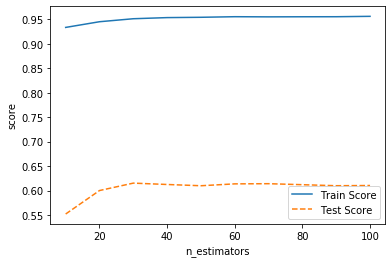

In [53]:
plt.plot(para_n_tree, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_n_tree, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("n_estimators") #score : 설명력 , n_estimators: 결정트리수
plt.legend()

- 생성하는 결정 트리 수 증가에 따라 모델의 설명력은 증가하며, 트리수가 30개를 초과해도 설명력은 거의 향상되지 않음. 
최대 트리 수에 따른 영향을 배제하고 다른 파라미터의 영향을 확인하고자 100 선택.

In [54]:
train_score = []; test_score = []

para_leaf = [n_leaf * 2 for n_leaf in range(1,21)]

for v_min_samples_leaf in para_leaf:
    rf = RFR(n_estimators=100, min_samples_leaf = v_min_samples_leaf, random_state=1234)
    
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    
#결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSamplesLeaf"]=para_leaf
df_score_leaf["TrainScore"]=train_score
df_score_leaf["TestScore"]=test_score

In [55]:
df_score_leaf.round(3)

,MinSamplesLeaf,TrainScore,TestScore
0,2,0.939,0.610
1,4,0.891,0.617
2,6,0.849,0.627
3,8,0.816,0.621
4,10,0.786,0.619
5,12,0.759,0.617
6,14,0.740,0.612
7,16,0.720,0.616
8,18,0.701,0.607
9,20,0.690,0.599


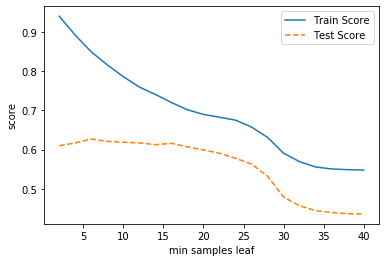

In [56]:
plt.plot(para_leaf, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle = "--", label = "Test Score")

plt.ylabel("score"); plt.xlabel("min samples leaf") #score : 설명력 , n_estimators: 결정트리수
plt.legend()

In [27]:
train_score = []; test_score = []

para_split = [n_split * 2 for n_split in range(2,21)]

for v_min_samples_split in para_split:
    rf = RFR(n_estimators=100, min_samples_split = v_min_samples_split, min_samples_leaf=6, random_state=1234)
    
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    
#결과 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"]=para_split
df_score_split["TrainScore"]=train_score
df_score_split["TestScore"]=test_score

In [29]:
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,4,0.849,0.627
1,6,0.849,0.627
2,8,0.849,0.627
3,10,0.849,0.627
4,12,0.849,0.627
5,14,0.839,0.629
6,16,0.831,0.629
7,18,0.821,0.628
8,20,0.813,0.628
9,22,0.803,0.628


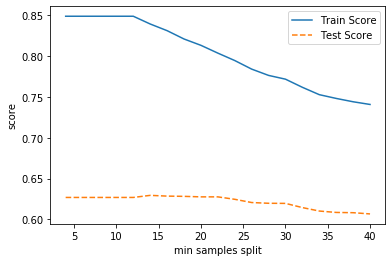

In [30]:
plt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples split") #score : 설명력 , n_estimators: 결정트리수
plt.legend()

In [31]:
train_score = []; test_score = []

para_depth = [depth for depth in range(1,11)]

for v_max_depth in para_depth:
    rf = RFR(n_estimators=100, min_samples_split = 14, max_depth = v_max_depth, min_samples_leaf=6, random_state=1234)
    
    rf.fit(df_train_x, df_train_y)
    train_score.append(rf.score(df_train_x,df_train_y))
    test_score.append(rf.score(df_test_x,df_test_y))
    
#결과 저장
df_score_depth = pd.DataFrame()
df_score_depth["Depth"]=para_depth
df_score_depth["TrainScore"]=train_score
df_score_depplt.plot(para_split, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_split, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("min samples split") #score : 설명력 , n_estimators: 결정트리수
plt.legend()th["TestScore"]=test_score

In [32]:
df_score_depth.round(3)

,Depth,TrainScore,TestScore
0,1,0.557,0.448
1,2,0.721,0.598
2,3,0.789,0.620
3,4,0.825,0.627
4,5,0.837,0.631
5,6,0.839,0.629
6,7,0.839,0.629
7,8,0.839,0.629
8,9,0.839,0.629
9,10,0.839,0.629


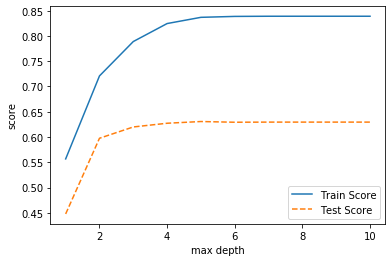

In [33]:
plt.plot(para_depth, train_score, linestyle = "-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle = "--", label = "Test Score")
plt.ylabel("score"); plt.xlabel("max depth") #score : 설명력 , n_estimators: 결정트리수
plt.legend()

In [37]:
rf_final = RFR(n_estimators=100, min_samples_split = 14, max_depth = 4, min_samples_leaf=6, random_state=1234)
    
rf_final.fit(df_train_x, df_train_y) 

#Train 데이터 설명력
print("Score on training set: {:.3f}".format(rf_final.score(df_train_x,df_train_y)))

#Test 데이터 설명력
print("Score on test set: {:.3f}".format(rf_final.score(df_test_x,df_test_y)))


Score on training set: 0.825
Score on test set: 0.627


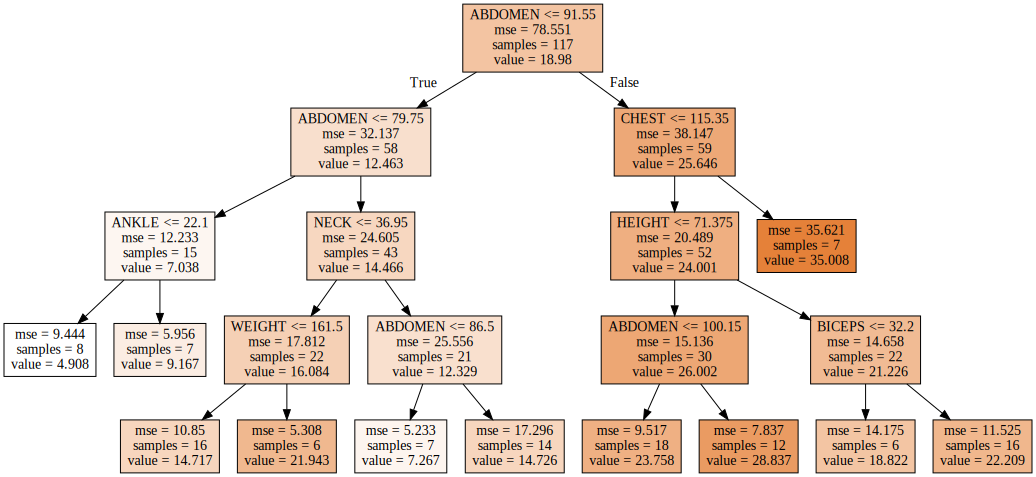

In [38]:
v_feature_name = df_train_x.columns

export_graphviz(rf_final.estimators_[0], out_file = "rfr_final_0.dot", feature_names = v_feature_name, impurity=True, filled = True)

with open("rfr_final_0.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

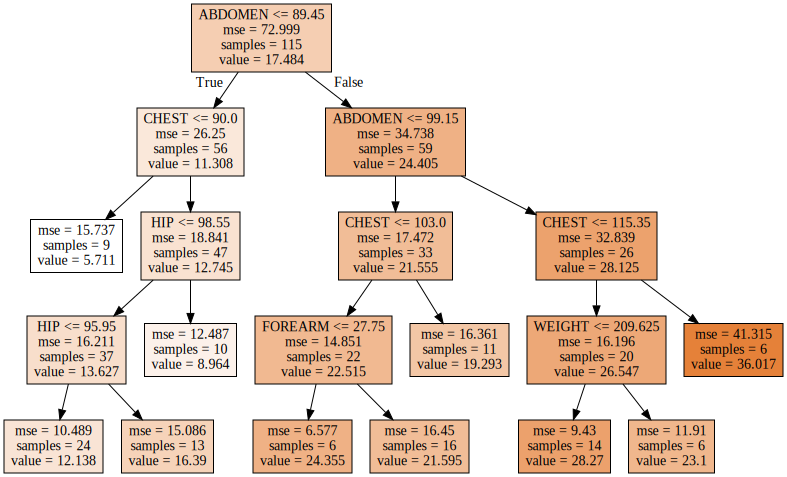

In [39]:

export_graphviz(rf_final.estimators_[1], out_file = "rfr_final_1.dot", feature_names = v_feature_name, impurity=True, filled = True)

with open("rfr_final_1.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

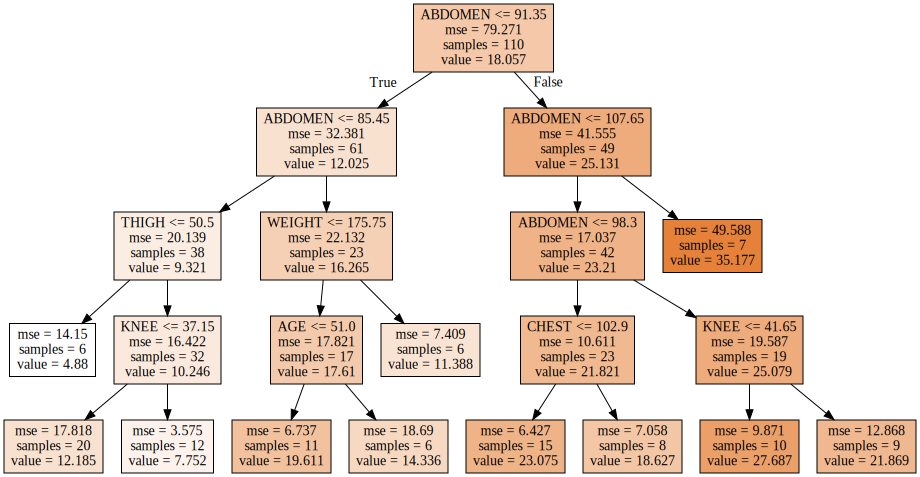

In [41]:
export_graphviz(rf_final.estimators_[10], out_file = "rfr_final_10.dot", feature_names = v_feature_name, impurity=True, filled = True)

with open("rfr_final_10.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

In [42]:
# feature_importance_: 설명변수의 중요도
# tree_final.feature_importances_로 설명변수 중요도 확인 및 테이블로 저장
df_importance = pd.DataFrame()
df_importance["Feature"] = v_feature_name
df_importance["Importance"] = rf_final.feature_importances_

# df_feature_importance의 테이블을 중요도별로 정렬split 
df_importance.sort_values("Importance",ascending=False, inplace=True)
df_importance.round(3)

,Feature,Importance
5,ABDOMEN,0.843
4,CHEST,0.036
2,HEIGHT,0.032
0,AGE,0.014
6,HIP,0.014
7,THIGH,0.011
12,WRIST,0.010
3,NECK,0.010
8,KNEE,0.009
1,WEIGHT,0.008


Text(0, 0.5, '변수')

/home/piai/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 48320 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 51473 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 50836 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/piai/anaconda3/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:180: Runtim

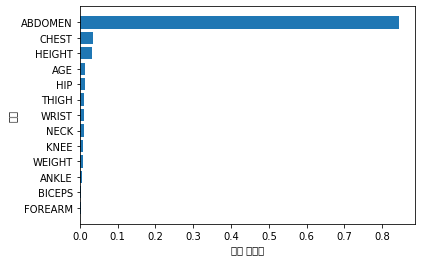

In [43]:
df_importance.sort_values("Importance", ascending=True, inplace = True)
coordinates = range(len(df_importance))
plt.barh(y= coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")